In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pennylane pennylane-lightning scikit-learn seaborn matplotlib --quiet



Train class distribution:
 attack_cat
Normal            74400
Generic           47097
Exploits          35620
Fuzzers           19397
DoS               13082
Reconnaissance    11189
Analysis           2142
Backdoor           1863
Shellcode          1209
Worms               139
Name: count, dtype: int64

Test class distribution:
 attack_cat
Normal            18600
Generic           11774
Exploits           8905
Fuzzers            4849
DoS                3271
Reconnaissance     2798
Analysis            535
Backdoor            466
Shellcode           302
Worms                35
Name: count, dtype: int64

Training QuantumFuzzyRandomForest with 64 features and 6 qubits
Predicting...


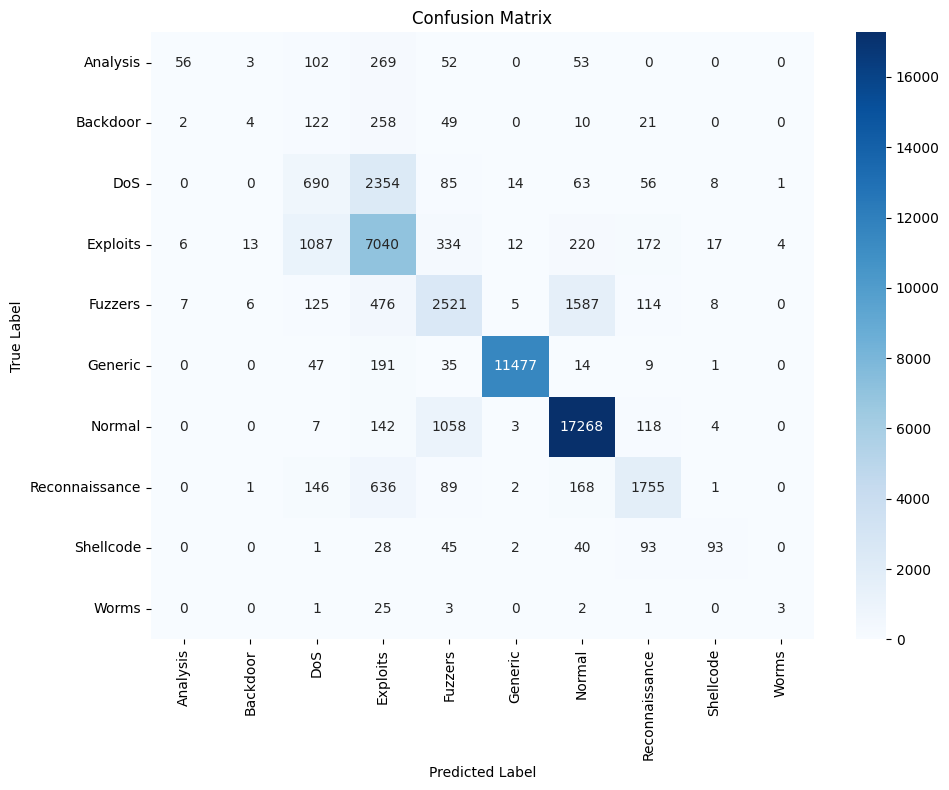


Evaluation Metrics:
Accuracy: 0.7938
Precision (macro): 0.6156
Recall (macro): 0.4559
F1 Score (macro): 0.4838

Class Labels:
['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Quantum-enhanced Random Forest Classifier
class QuantumFuzzyRandomForest:
    def __init__(self, n_estimators=100, n_qubits=6):
        self.n_estimators = n_estimators
        self.n_qubits = n_qubits
        self.input_dim = 2 ** self.n_qubits
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)

            # Add parameterless variational block for better expressiveness
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])

            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.rf_model = RandomForestClassifier(n_estimators=self.n_estimators, random_state=42)
        self.rf_model.fit(self.X_train_encoded, y_train)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded)
        return self.rf_model.predict(X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)

# Filter and cast label column
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)

# === Print Class Distribution ===
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])

# === Train Model ===
print(f"\nTraining QuantumFuzzyRandomForest with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyRandomForest(n_estimators=100, n_qubits=6)
model.fit(X_train, y_train)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)


xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Quantum-enhanced XGBoost Classifier
class QuantumFuzzyXGBoost:
    def __init__(self, n_estimators=100, n_qubits=6):
        self.n_estimators = n_estimators
        self.n_qubits = n_qubits
        self.input_dim = 2 ** self.n_qubits
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.xgb_model = XGBClassifier(n_estimators=self.n_estimators, use_label_encoder=False, eval_metric='mlogloss')
        self.xgb_model.fit(self.X_train_encoded, y_train)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded)
        return self.xgb_model.predict(X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])

# === Train Model ===
print(f"\nTraining QuantumFuzzyXGBoost with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyXGBoost(n_estimators=100, n_qubits=6)
model.fit(X_train, y_train)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)


knn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Quantum-enhanced KNN Classifier
class QuantumFuzzyKNN:
    def __init__(self, n_neighbors=5, n_qubits=6):
        self.n_neighbors = n_neighbors
        self.n_qubits = n_qubits
        self.input_dim = 2 ** self.n_qubits
        self.dev = qml.device("default.qubit", wires=self.n_qubits)

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.knn_model = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.knn_model.fit(self.X_train_encoded, y_train)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded)
        return self.knn_model.predict(X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])

# === Train Model ===
print(f"\nTraining QuantumFuzzyKNN with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyKNN(n_neighbors=5, n_qubits=6)
model.fit(X_train, y_train)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)


lstm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Quantum-enhanced LSTM Classifier
class QuantumFuzzyLSTM:
    def __init__(self, n_qubits=6, input_timesteps=1, hidden_units=64, dropout=0.3, epochs=10, batch_size=32):
        self.n_qubits = n_qubits
        self.input_dim = 2 ** n_qubits
        self.input_timesteps = input_timesteps
        self.hidden_units = hidden_units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train, num_classes):
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.X_train_encoded = self.X_train_encoded.reshape(-1, self.input_timesteps, self.input_dim)

        y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

        # Define LSTM model
        self.model = Sequential([
            Input(shape=(self.input_timesteps, self.input_dim)),
            LSTM(self.hidden_units, return_sequences=False),
            Dropout(self.dropout),
            Dense(num_classes, activation='softmax')
        ])

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(self.X_train_encoded, y_train_categorical, epochs=self.epochs, batch_size=self.batch_size, verbose=1)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded).reshape(-1, self.input_timesteps, self.input_dim)
        y_probs = self.model.predict(X_encoded)
        return np.argmax(y_probs, axis=1)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])
num_classes = len(np.unique(y_train))

# === Train Model ===
print(f"\nTraining QuantumFuzzyLSTM with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyLSTM(n_qubits=6, input_timesteps=1, hidden_units=64, epochs=10, batch_size=32)
model.fit(X_train, y_train, num_classes=num_classes)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)


decision tree


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Quantum-enhanced Decision Tree Classifier
class QuantumFuzzyDecisionTree:
    def __init__(self, n_qubits=6, max_depth=None):
        self.n_qubits = n_qubits
        self.input_dim = 2 ** n_qubits
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.max_depth = max_depth

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train):
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.tree_model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
        self.tree_model.fit(self.X_train_encoded, y_train)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded)
        return self.tree_model.predict(X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])

# === Train Model ===
print(f"\nTraining QuantumFuzzyDecisionTree with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyDecisionTree(n_qubits=6, max_depth=15)
model.fit(X_train, y_train)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)


ANN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Quantum-enhanced ANN Classifier
class QuantumFuzzyANN:
    def __init__(self, n_qubits=6, hidden_layer_sizes=(100,), max_iter=300):
        self.n_qubits = n_qubits
        self.input_dim = 2 ** n_qubits
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter

    def amplitude_encoding(self, x):
        norm = np.linalg.norm(x)
        return x / norm if norm != 0 else x

    def create_kernel_circuit(self, encoded_input):
        @qml.qnode(self.dev)
        def circuit():
            qml.AmplitudeEmbedding(features=encoded_input, wires=range(self.n_qubits), normalize=True)
            for i in range(self.n_qubits):
                qml.RY(np.pi / 4, wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            return qml.state()
        return circuit

    def execute_circuits(self, circuits):
        return np.array([pnp.abs(circuit())**2 for circuit in circuits])

    def fit(self, X_train, y_train):
        X_encoded = []
        for x in X_train:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        self.X_train_encoded = np.array(X_encoded)
        self.ann_model = MLPClassifier(hidden_layer_sizes=self.hidden_layer_sizes,
                                       max_iter=self.max_iter, random_state=42)
        self.ann_model.fit(self.X_train_encoded, y_train)

    def predict(self, X_test):
        X_encoded = []
        for x in X_test:
            x_enc = self.amplitude_encoding(x)
            circuit = self.create_kernel_circuit(x_enc)
            result = self.execute_circuits([circuit])[0]
            X_encoded.append(result)
        X_encoded = np.array(X_encoded)
        return self.ann_model.predict(X_encoded)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# === Load data ===
df_train = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/casptone2/UNSW_NB15_testing-set.csv")

df = pd.concat([df_train, df_test], ignore_index=True)
df.dropna(inplace=True)
df = df[df['attack_cat'].notna()]
df['attack_cat'] = df['attack_cat'].astype(str)

# === Stratified split ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['attack_cat'], random_state=42)
print("\nTrain class distribution:\n", train_df['attack_cat'].value_counts())
print("\nTest class distribution:\n", test_df['attack_cat'].value_counts())

# === Identify Columns ===
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()
for col in ['attack_cat', 'label', 'id']:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

# === Encode Categorical Columns ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols].astype(str))
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols].astype(str))

# === Prepare Features ===
X_train = train_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')
X_test = test_df.drop(columns=['attack_cat', 'label', 'id'], errors='ignore')

# === Scale Numeric Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Pad Data to Match Quantum Circuit (2^n_qubits = 64) ===
def pad_data(X, target_len):
    current_len = X.shape[1]
    if current_len < target_len:
        return np.pad(X, ((0, 0), (0, target_len - current_len)), mode='constant')
    elif current_len > target_len:
        return X[:, :target_len]
    return X

max_len = 2 ** 6
X_train = pad_data(X_train, max_len)
X_test = pad_data(X_test, max_len)

# === Encode Labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['attack_cat'])
y_test = label_encoder.transform(test_df['attack_cat'])

# === Train Model ===
print(f"\nTraining QuantumFuzzyANN with {X_train.shape[1]} features and 6 qubits")
model = QuantumFuzzyANN(n_qubits=6, hidden_layer_sizes=(128, 64), max_iter=300)
model.fit(X_train, y_train)

# === Predict ===
print("Predicting...")
y_pred = model.predict(X_test)

# === Evaluation ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix, label_encoder.classes_)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClass Labels:")
print(label_encoder.classes_)
